This is a demo based on the FitNet-4 classifier for probablistic and evidential classification, which can be run on the google colab.

Please check two points before running the demo:
1. Use GPU or TPU in Google colab to improve the running speed as:
edit >> Notebook setting >> Hardware accelerator >> Select GPU or TPU >> Save.

2. Check the versions of the used libs, especially TensorFlow. The required versions of these libs can be found in the readme file.

The first step is to import the pre-requisite libs as below.
The required versions of these libs can be found in the readme file.

In [1]:
import tensorflow as tf
import sys
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print("python版本:%s"% sys.version)

from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/cifar10_evidential/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

from scipy.optimize import minimize
import math
import numpy as np

Mounted at /content/gdrive


Let's get and pre-process the CIFAR-10 database.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train=x_train.astype("float32") / 255.0
x_test=x_test.astype("float32") / 255.0
y_train_label = y_train
y_test_label = y_test
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

170500096/170498071 [==============================] - 6s 0us/step


Let's build a probablistic FitNet-4 classifier.

In the demo, we use the fixed learning rate and do not introduce data augmentation as well as some other technologies because the demo just try to show the difference between evidential and proabilistic FitNet-4 classifiers. If users wish to achieve the resutls reported in the papers ('Fitnets: Hints for thin deep nets' and 'All you need is a good init'), please refer their hyper-parameters.

In [ ]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
num_class=10

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)

flatten1=tf.keras.layers.Flatten()(dr3)

outputs = tf.keras.layers.Dense(num_class, activation='softmax')(flatten1)

model_p = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_p.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #lr=0.005
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_p.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 48)        192   

Let's train the probabilistic FitNet classifier.

In the demo, the weights will be saved if the validation average utility is  improved after one epoch.

As mentioned in our paper, when only considering the precise classification during training, the average utility equals to the average accuracy.

Users is suggested to stop training when the training accuracy is close to 1. The authors also provide the weights of the model in the model zoo, users can directly load it in the next cell, instead of strating with pre-training.

In [ ]:
filepath = ''#please define our own filepath to save the weights of the probabilistic FitNet-4 classifier
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)

model_p.fit(x_train, y_train, batch_size=25, epochs=200, verbose=1, callbacks=[checkpoint_callback], validation_data=(x_test, y_test), shuffle=True)

In [ ]:
model_p.load_weights('/content/gdrive/My Drive/cifar10_evidential/weights_zoo/cnn_checkpoint_final')# replace the path with your own
model_p.evaluate(x_train, y_train, batch_size=25, verbose=1)
model_p.evaluate(x_test, y_test, batch_size=25, verbose=1)

400/400 [==============================] - 1s 3ms/step - loss: 0.8291 - accuracy: 0.8708


[0.8290520310401917, 0.8708000183105469]

Let's build an evidential FitNet-4 classifier.

Compared to the probabilistic one, the evidential classifier has the extra hyper-parameters: the number of prototypes and pessimism index \nu (if use generalized Hurwicz decision criterion). The classifier has 200 prototypes and uses the generalized Hurwicz decision criterion with \nu=0.9. The two hyper-parameters can be tuned using a validation set or by cross-validation.

We also provide the utility layer based on Pignistic criterion, please find the details in utility_layer_train.py.

In the demo, we use the fixed learning rate and do not introduce data augmentation as well as some other technologies because the demo just try to show the difference between evidential and proabilistic FitNet-4 classifiers. If users wish to achieve the resutls reported in the paper ('Fitnets: Hints for thin deep nets' and 'All you need is a good init'), please refer their hyper-parameters.

In [34]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=200
num_class=10

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#convolution stages
c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

#DS layer
ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

#Utility layer for training
outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)


model_e = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 48)        192

The training beginning with random  initialized parameters is time consuming and slow. The authors suggests users directly use the weights from probabilistic CNN classifier and then fine-tune the paramters in DS layer and golable weights in the evidential CNN classifier as shown in the cell. If a user want to just use the well-trained classifier, please see the next cell.

In [35]:
#get the features using the probabilistic classifier
model_e.load_weights('') #please give our own filepath to save the weights of the probabilistic FitNet-4 classifier
feature = tf.keras.Model(inputs=[inputs], outputs=[flatten1])
x_train_feature = feature.predict(x_train)
x_test_feature = feature.predict(x_test)

#Use the features to train DS layer
inputs = tf.keras.layers.Input(128)
ED = ds_layer.DS1(prototypes,128)(inputs)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
outputs = utility_layer_train.DM(0.9, num_class)(mass_Dempster_normalize)
model_mid = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_mid.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), #0.001
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_mid.fit(x_train_feature, y_train, batch_size=25,  epochs=2, verbose=1, validation_data=(x_test_feature, y_test), shuffle=True)

#give the trained paramters to the evidential model
model_e.load_weights('')#please give our own filepath to save the weights of the probabilistic FitNet-4 classifier
DSLAYER_DS1_W = tf.reshape(model_mid.layers[1].get_weights()[0], [1, 200, 128])
DSLAYER_DS1_activate_W = model_mid.layers[2].get_weights()
DSLAYER_DS2_W = model_mid.layers[3].get_weights()
model_e.layers[26].set_weights(DSLAYER_DS1_W)
model_e.layers[27].set_weights(DSLAYER_DS1_activate_W)
model_e.layers[28].set_weights(DSLAYER_DS2_W)

#fine-tune the golable weights in the evidential CNN classifier and evaluate the classifier
filepath = ''#define our own path to save the weights of the evidential FitNet-4 classifier
checkpoint_callback = ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=1,
    save_best_only=True, save_weights_only=True,
    save_frequency=1)
model_e.fit(x_train, y_train, batch_size=25,  epochs=3, verbose=1, callbacks=[checkpoint_callback], validation_data=(x_test, y_test), shuffle=True)

Epoch 1/3
2000/2000 [==============================] - 276s 106ms/step - loss: 1.2926 - accuracy: 0.5521 - val_loss: 0.7246 - val_accuracy: 0.8548
Epoch 2/3
2000/2000 [==============================] - 200s 100ms/step - loss: 0.1199 - accuracy: 0.9903 - val_loss: 0.7743 - val_accuracy: 0.8576
Epoch 3/3
2000/2000 [==============================] - 199s 100ms/step - loss: 0.0661 - accuracy: 0.9937 - val_loss: 0.8522 - val_accuracy: 0.8683
Epoch 1/3
2000/2000 [==============================] - 503s 217ms/step - loss: 0.2390 - accuracy: 0.9407 - val_loss: 0.7635 - val_accuracy: 0.8649

Epoch 00001: val_accuracy improved from -inf to 0.86490, saving model to /content/gdrive/My Drive/evidential_DL_200_checkpoint
Epoch 2/3
2000/2000 [==============================] - 418s 209ms/step - loss: 0.0699 - accuracy: 0.9877 - val_loss: 0.8444 - val_accuracy: 0.8648

Epoch 00002: val_accuracy did not improve from 0.86490
Epoch 3/3
2000/2000 [==============================] - 419s 209ms/step - loss: 0.

[0.8489488363265991, 0.8751000165939331]

After training, the average utility of evidential classifier is slightly higer than the one of probablisitic classifier.

In [ ]:
model_e.load_weights('/content/gdrive/My Drive/cifar10_evidential/weights_zoo/evidential_DL_200_checkpoint')
model_e.evaluate(x_train, y_train, batch_size=25, verbose=1)
model_e.evaluate(x_test, y_test, batch_size=25, verbose=1)


Two checkpoint references resolved to different objects (<ds_layer.DS2 object at 0x7f0aa3c47210> and <ds_layer.DS3_normalize object at 0x7f0aa3b8d710>).
400/400 [==============================] - 8s 19ms/step - loss: 0.6747 - accuracy: 0.8757


[0.6746578216552734, 0.8756999969482422]

Let's see the set-valued classificaiton of the evidential FitNet-4 classifier. 

We first generate a utility matrix.

In [36]:
# aim func: cross entropy
def func(x):
  fun=0
  for i in range(len(x)):
    fun += x[i] * math.log10(x[i])
  return fun

#constraint 1: the sum of weights is 1
def cons1(x):
  return sum(x)

#constraint 2: define tolerance to imprecision
def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol

In [37]:
#compute the weights g for ordered weighted average aggreagtion
num_class = 10
for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  locals()['weight'+str(j)]= np.zeros([5, j])

  for i in range(5):
    tol = 0.5 + i * 0.1

    cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
          {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
          {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
        )
  
    res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
    locals()['weight'+str(j)][i] = res.x
    print (res.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.30102999566398125
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.5 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.6 0.4]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2652949955741215
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.7 0.3]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.2173220112736488
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[0.8 0.2]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.1411817415046075
           

In [38]:
#function for power set
def PowerSetsBinary(items):  
    #generate all combination of N items  
    N = len(items)  
    #enumerate the 2**N possible combinations  
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all

In [39]:
class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set)
print(act_set)
print(len(act_set))
#label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
#              5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 9], [0, 1, 2, 3, 4, 5, 6, 8], [0, 1, 2, 3, 4, 5, 6, 8, 9], [0, 1, 2, 3, 4, 5, 6, 9], [0, 1, 2, 3, 4, 5, 7], [0, 1, 2, 3, 4, 5, 7, 8], [0, 1, 2, 3, 4, 5, 7, 8, 9], [0, 1, 2, 3, 4, 5, 7, 9], [0, 1, 2, 3, 4, 5, 8], [0, 1, 2, 3, 4, 5, 8, 9], [0, 1, 2, 3, 4, 5, 9], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 6, 7], [0, 1, 2, 3, 4, 6, 7, 8], [0, 1, 2, 3, 4, 6, 7, 8, 9], [0, 1, 2, 3, 4, 6, 7, 9], [0, 1, 2, 3, 4, 6, 8], [0, 1, 2, 3, 4, 6, 8, 9], [0, 1, 2, 3, 4, 6, 9], [0, 1, 2, 3, 4, 7], [0, 1, 2, 3, 4, 7, 8], [0, 1, 2, 3, 4, 7, 8, 9], [0, 1, 2, 3, 4, 7, 9], [0, 1, 2, 3, 4, 8], [0, 1, 2, 3, 4, 8, 9], [0, 1, 2, 3, 4, 9], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5, 6], [0, 1, 2, 3, 5, 6, 7], [0, 1, 2, 3, 5, 6, 7, 8], [0, 1, 2, 3, 5, 6, 7, 8, 9], [0, 1, 2, 3, 5, 6, 7, 9], [0, 1, 2, 3, 5, 6, 8], [0, 1, 2, 3, 

In [40]:
utility_matrix = np.zeros([len(act_set), len(class_set)])
tol_i = 3 
#tol_i = 0 with tol=0.5, tol_i = 1 with tol=0.6, tol_i = 2 with tol=0.7, tol_i = 3 with tol=0.8, tol_i = 4 with tol=0.9
for i in range(len(act_set)):
  intersec = class_set and act_set[i]
  if len(intersec) == 1:
    utility_matrix[i, intersec] = 1
  
  else:
    for j in range(len(intersec)):
      utility_matrix[i, intersec[j]] = locals()['weight'+str(len(intersec))][tol_i, 0]
print (utility_matrix)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.8        0.8        0.         ... 0.         0.         0.        ]
 [0.68208412 0.68208412 0.68208412 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.8        0.8       ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


Let's build the evidential FitNet-4 classifier for set-valued classification. Compared to the classifier with only precise classification, the testing classifier have extra expected utilities for all imprecise assignments if considering all possible subsets. Thus, we can directly get the weights from the previous classifiers without extra training.

In [41]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 3
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
prototypes=200
num_class=10
number_act_set = len(act_set)

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#convolution stages
c1_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_1)
c1_3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_2)
c1_4 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_3)
c1_5 = tf.keras.layers.Conv2D(48, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1_4)
bt1 = tf.keras.layers.BatchNormalization()(c1_5)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(bt1)
dr1 = tf.keras.layers.Dropout(0.5)(p1)


c2_1 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr1)
c2_2 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_1)
c2_3 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_2)
c2_4 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_3)
c2_5 = tf.keras.layers.Conv2D(80, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2_4)
bt2 = tf.keras.layers.BatchNormalization()(c2_5)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(bt2)
dr2 = tf.keras.layers.Dropout(0.5)(p2)

c3_1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(dr2)
c3_2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_1)
c3_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_2)
c3_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_3)
c3_5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3_4)
bt3 = tf.keras.layers.BatchNormalization()(c3_5)
p3 = tf.keras.layers.MaxPooling2D((8, 8))(bt3)
dr3 = tf.keras.layers.Dropout(0.5)(p3)
flatten1=tf.keras.layers.Flatten()(dr3)

#DS layer
ED = ds_layer.DS1(prototypes,128)(flatten1)
ED_ac = ds_layer.DS1_activate(prototypes)(ED)
mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
mass_prototypes_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_prototypes_omega)
mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)

#Utility layer for testing
outputs = utility_layer_test.DM_test(num_class, number_act_set, 0.9)(mass_Dempster_normalize)


model_e_imprecise = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_e_imprecise.compile(optimizer=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004), 
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])
model_e_imprecise.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 32, 32, 48)        13872     
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 48)        192

In [ ]:
model_e_imprecise.layers[-1].set_weights(tf.reshape(utility_matrix, [1, 1023, 10]))
model_e_imprecise.load_weights('/content/gdrive/My Drive/cifar10_evidential/weights_zoo/evidential_DL_200_checkpoint')

When the tolerance of imprecision equals to 0.8, the average utility is higher than the one in precise classification, and we can find some samples that are mis-classified in the precise classification are assigned into the multi-class sets, which includes the true labels, such as sample 37 and 128.

In [45]:
resutls = tf.argmax(model_e_imprecise.predict(x_test),-1)
imprecise_results =[]
for i in range(len(resutls)):
  act_local = resutls[i]
  set_valued_results = act_set[act_local]
  imprecise_results.append(set_valued_results)
print (imprecise_results)
average_utility_imprecision = AU_imprecision.average_utility(utility_matrix, resutls, y_test_label, act_set)
print (average_utility_imprecision)

[[3], [8], [1], [0], [6], [6], [1], [2, 6, 9], [3], [1], [0], [9], [5], [7], [9], [8], [5], [7], [8], [6], [3, 7], [2], [4], [9], [4, 7], [2, 4, 7], [3], [0], [9], [6], [6], [5], [4, 6], [5], [9], [2, 6, 8], [4], [1], [9], [5], [0, 4], [6], [5], [6], [0], [9], [3], [9], [7], [6], [9], [8], [0], [3], [8], [8], [7], [3], [4], [0, 3, 4], [7], [7], [6], [3], [6], [2], [1], [2], [3], [7], [2], [6], [8], [8], [0], [2, 9], [9], [3], [5], [8], [8], [1], [1], [7], [2], [5], [2], [7], [8], [9], [0], [3], [8], [6], [4], [6], [6], [0], [0], [7], [4], [5], [6], [3], [1], [1], [3], [6], [8], [7], [4], [0], [6], [2], [1], [3], [0], [4], [2, 6], [7], [8], [3], [1], [2], [8], [0], [8], [3], [0, 4], [2], [4], [1], [8], [9], [1], [2], [9], [7], [2], [1], [6], [5], [6], [3], [8], [7], [6], [5], [5], [2], [8], [9], [6], [0], [0], [5], [2], [9], [2, 3], [4], [2], [1], [6], [6], [0], [4], [8], [4], [5], [8], [9], [0, 9], [9], [2, 6, 8], [9], [9], [3], [7], [5], [0], [0], [5], [2], [2], [3], [8], [2, 6], [3],

lable:  [6]
prediction:  [2, 6, 9]


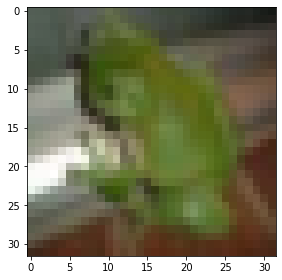

lable:  [7]
prediction:  [3, 7]


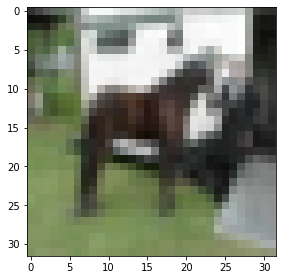

lable:  [2]
prediction:  [2, 4, 7]


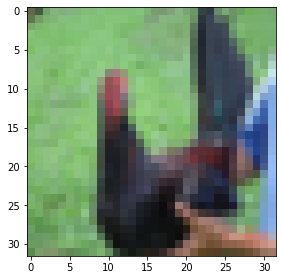

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
imshow(x_test[7])
print ('lable: ',y_test_label[7])
print ('prediction: ',imprecise_results[7])
plt.show()
imshow(x_test[20])
print ('lable: ',y_test_label[20])
print ('prediction: ',imprecise_results[20])
plt.show()
imshow(x_test[25])
print ('lable: ',y_test_label[25])
print ('prediction: ',imprecise_results[25])
plt.show()
#label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
#              5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}